## Amazon Product Review Analysis 

              precision    recall  f1-score   support

    negative       0.80      0.31      0.44        65
     neutral       0.00      0.00      0.00        28
    positive       0.92      1.00      0.96       890

    accuracy                           0.92       983
   macro avg       0.57      0.43      0.47       983
weighted avg       0.89      0.92      0.90       983

{'Topic 1': ['what', 'does', 'works', 'my', 'great', 'card', 'its', 'memory', 'good', 'say'], 'Topic 2': ['sandisk', 'memory', 'card', 'gb', 'my', 'great', 'price', 'sd', 'good', 'product'], 'Topic 3': ['my', 'no', 'galaxy', 'works', 'samsung', 'great', 'have', 'issues', 'card', 'problems'], 'Topic 4': ['gopro', 'my', 'video', 'great', 'works', 'hero', 'camera', 'use', 'recording', 'card'], 'Topic 5': ['card', 'my', 'but', 'not', 'have', 'phone', 'you', 'one', 'had', 'so']}


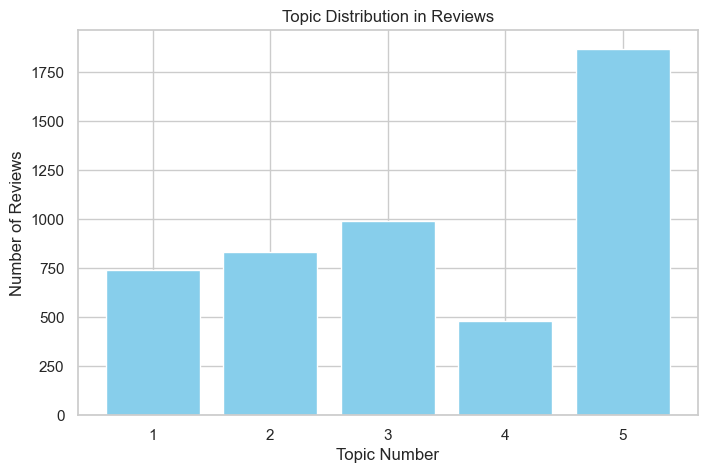

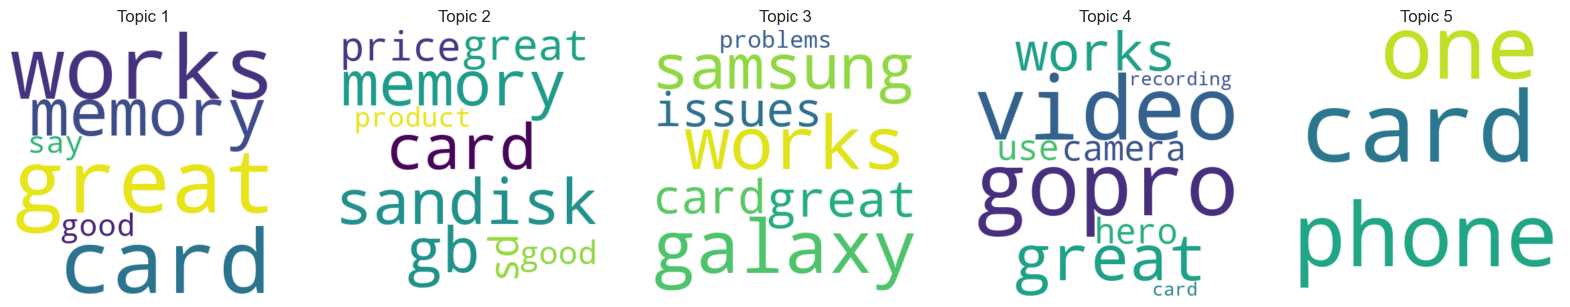

In [118]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.decomposition import LatentDirichletAllocation

# Load Dataset
file_path = "amazon_review.csv"
df = pd.read_csv(file_path)

# Text Cleaning Function
def clean_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
        stopwords = {"the", "and", "is", "in", "it", "this", "that", "for", "on", "with", "as", "was", "are", "at", "by", "an", "be", "or", "to", "of", "a"}
        words = text.split()
        words = [word for word in words if word not in stopwords]
        return " ".join(words)
    return ""

# Apply Cleaning
df["cleaned_review"] = df["reviewText"].apply(clean_text)

# TF-IDF Feature Extraction
tfidf_vectorizer = TfidfVectorizer(max_features=500)
tfidf_matrix = tfidf_vectorizer.fit_transform(df["cleaned_review"].fillna(""))

# Sentiment Labeling
def map_sentiment(rating):
    if rating >= 4:
        return "positive"
    elif rating == 3:
        return "neutral"
    else:
        return "negative"

df["sentiment"] = df["overall"].apply(map_sentiment)

# Train/Test Split
X = tfidf_matrix
y = df["sentiment"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train Logistic Regression Model
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Evaluate Model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

# LDA Topic Modeling
num_topics = 5
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda_topics = lda_model.fit_transform(tfidf_matrix)

def get_top_words(model, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[f"Topic {topic_idx+1}"] = top_words
    return topics

top_words_per_topic = get_top_words(lda_model, tfidf_vectorizer.get_feature_names_out())
print(top_words_per_topic)

# Topic Distribution Plot
topic_assignments = np.argmax(lda_topics, axis=1)
topic_counts = np.bincount(topic_assignments, minlength=5)

plt.figure(figsize=(8, 5))
plt.bar(range(1, 6), topic_counts, color="skyblue")
plt.xlabel("Topic Number")
plt.ylabel("Number of Reviews")
plt.title("Topic Distribution in Reviews")
plt.xticks(range(1, 6))
plt.show()

# Word Clouds for Topics
fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, (topic, words) in enumerate(top_words_per_topic.items()):
    wordcloud = WordCloud(background_color="white", width=400, height=400).generate(" ".join(words))
    axes[i].imshow(wordcloud, interpolation="bilinear")
    axes[i].axis("off")
    axes[i].set_title(topic)
plt.show()

In [124]:
!pip install transformers torch

